# Experiments

These notebook is intended to retrieve the data from the experiments data storaged in the CSV files

In [13]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os

In [14]:
results_folder = "results"
results_columns = [
    "TraditionalSceneRenderTime",
    "IndirectObjectBatchBuildTime",
    "IndirectDrawBatchBuildTime",
    "IndirectShaderBatchBuildTime",
    "IndirectObjectBufferRefreshTime",
    "IndirectObjectHandleBufferRefreshTime",
    "IndirectMaterialBufferRefreshTime",
    "IndirectIndirectBufferRefreshTime",
    "IndirectSceneRenderTime",
    "DataGenerationTime",
    "TerrainRenderTime",
    "ObjectsPlacesGenerationTime",
    "AddedTraditionalObjects",
    "AddedIndirectObjects",
    "ChunksLoaded",
    "ObjectPlacesGenerated",
]

## Number of Objects

Average statistics per frame when running an application with a permanent amount of objects

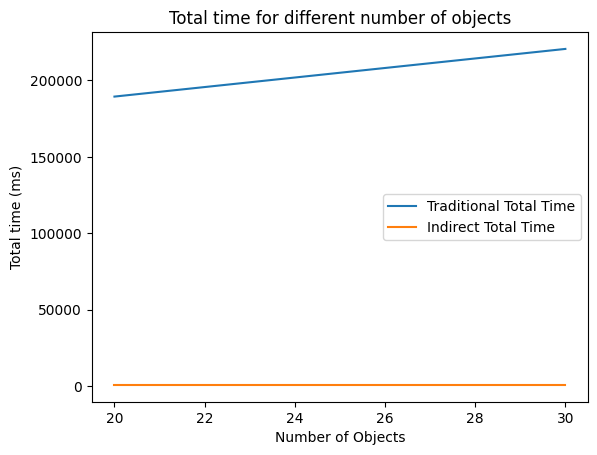

In [29]:
def extract_number_of_objects_from_filename(filename):
    # Assuming the size is part of the filename, e.g., "NumberOfObjects-Indirect-256.csv"
    noo = filename.split('-')[-1].replace('.csv', '')
    return int(noo)

def get_merged_df(csv_files):
    # List to hold individual DataFrames
    dataframes = []

    for file in csv_files:
        # Read the CSV file
        df = pd.read_csv(file, header=None)
        # Add columns
        df.columns = results_columns
        # Extract size from filename and add as a new column
        df['noo'] = extract_number_of_objects_from_filename(file)
        # Append to the list of DataFrames
        dataframes.append(df)

    # Concatenate all DataFrames into one
    merged_df = pd.concat(dataframes, ignore_index=True)

    # Reorder columns to match the desired output
    merged_df = merged_df[["noo"] + results_columns]
    
    return merged_df

def add_sum_column(df, column_name, columns_to_sum):
    df[column_name] = df[columns_to_sum].sum(axis=1)
    return df

prefix = "NumberOfObjects"

traditional_files = []
indirect_files = []

for result_file in os.listdir(results_folder):
    if prefix in result_file:  
        if "Traditional" in result_file:
            traditional_files.append(results_folder + "/" + result_file)
        elif "Indirect" in result_file:
            indirect_files.append(results_folder + "/" + result_file)
            
traditional_merged_df = get_merged_df(traditional_files)
indirect_merged_df = get_merged_df(indirect_files)

# Average total time for each number of objects
traditional_avg = traditional_merged_df.groupby("noo").mean()
indirect_avg = indirect_merged_df.groupby("noo").mean()

traditional_final = add_sum_column(traditional_avg, "TotalFrameTime", ["TraditionalSceneRenderTime"])
indirect_batch = add_sum_column(indirect_avg, "BatchBuildTime", ["IndirectObjectBatchBuildTime", "IndirectDrawBatchBuildTime", "IndirectShaderBatchBuildTime"])
indirect_buffer = add_sum_column(indirect_batch, "BufferRefreshTime", ["IndirectObjectBufferRefreshTime", "IndirectObjectHandleBufferRefreshTime", "IndirectMaterialBufferRefreshTime", "IndirectIndirectBufferRefreshTime"])
indirect_final = add_sum_column(indirect_buffer, "TotalFrameTime", ["BatchBuildTime", "BufferRefreshTime", "IndirectSceneRenderTime"])

fig, ax = plt.subplots()
ax.plot(traditional_final.index, traditional_final["TotalFrameTime"], label="Traditional Total Time")
ax.plot(indirect_final.index, indirect_final["TotalFrameTime"], label="Indirect Total Time")
ax.set_xlabel("Number of Objects")
ax.set_ylabel("Total time (ms)")
ax.legend()
plt.title("Total time for different number of objects")
plt.show()

In [ ]:
def fill_dataset(path, title):
    print("reading", path, title)
    df = pd.read_csv(path, header=None)
    fig, ax = plt.subplots()
    fig_title = compute_fig_title(path, title)
    
    if title == 'iterations':
        ax.plot(df[0], df[1])
        ax.set_xlabel('time (s)')
        ax.set_ylabel('iterations')
        ax.set_xlim(left=0)
        ax.set_ylim(bottom=0)
    elif title == 'particles-per-second':
        ax.plot(df[0], df[1])
        ax.set_xlabel('time (s)')
        ax.set_ylabel('particles/second')
        ax.set_xlim(left=0)
        ax.set_ylim(bottom=min(df[1])*0.95)  # log scale can't handle 0, obviously
        #ax.set_yscale('log')
    
    ax.set_title(fig_title)
    
    if not os.path.exists('plots'):
        os.makedirs('plots')
    fig.savefig(os.path.join('plots', fig_title+'.jpg'))